In [1]:
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 

from data import Data, squiggle
from modules import MLP

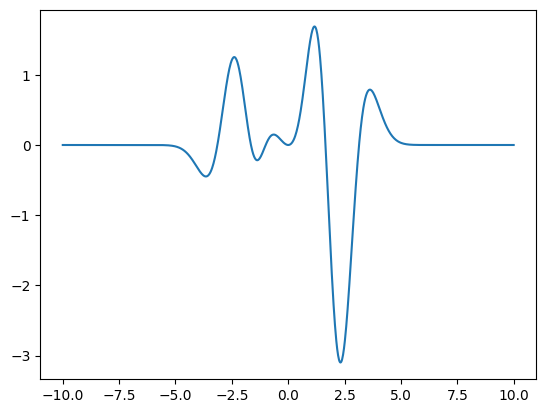

In [2]:
x = np.linspace(-10,10,1000)
plt.plot(x, squiggle(x))
plt.show()

In [3]:
class NLLModel(nn.Module):
  def __init__(self, dropout=0.05, hidden_size=128, num_layers=2, dist=torch.distributions.Normal):
    super().__init__()
    self.dist = dist
    self.model = MLP(hidden_size=hidden_size, dropout=dropout, num_layers=num_layers, num_outputs=2)
    
  def forward(self, x):
    mu_sigma = self.model(x)
    return mu_sigma[:,:1], F.softplus(mu_sigma[:,1:])

  def forward_dist(self, x):
    mu, sigma = self.forward(x)
    return self.dist(mu, sigma)
  
  def compute_loss(self, x, y):
    dist = self.forward_dist(x)
    return -dist.log_prob(y).mean()

In [4]:
dl_train = DataLoader(Data(squiggle, low=-4, high=4, seed=1, sigma=.1), batch_size=32, shuffle=True, drop_last=True)
dl_val = DataLoader(Data(squiggle,  low=-4, high=4, seed=2, sigma=.1), batch_size=32, shuffle=True, drop_last=True)

model = NLLModel()
optimizer = torch.optim.AdamW(model.parameters(), lr=6e-4, weight_decay=1e-2)

In [5]:
for epoch in range(500):
  model.train()
  train_loss = []
  for batch in dl_train:
    x, y = batch
    loss = model.compute_loss(x, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  model.eval()
  val_loss = []
  with torch.no_grad():
    for batch in dl_val:
      x, y = batch
      loss = model.compute_loss(x, y)
      val_loss.append(loss.item())
  if epoch % 20 == 0:
    print(f"Epoch {epoch}, train loss: {np.mean(train_loss):.02f}, val loss: {np.mean(val_loss):.02f}")

Epoch 0, train loss: 1.35, val loss: 1.19
Epoch 20, train loss: -0.03, val loss: -0.26
Epoch 40, train loss: -0.18, val loss: -0.35
Epoch 60, train loss: -0.32, val loss: -0.54
Epoch 80, train loss: -0.34, val loss: -0.58
Epoch 100, train loss: -0.37, val loss: -0.56
Epoch 120, train loss: -0.36, val loss: -0.56
Epoch 140, train loss: -0.39, val loss: -0.61
Epoch 160, train loss: -0.41, val loss: -0.55
Epoch 180, train loss: -0.36, val loss: -0.56
Epoch 200, train loss: -0.45, val loss: -0.55
Epoch 220, train loss: -0.45, val loss: -0.63
Epoch 240, train loss: -0.51, val loss: -0.70
Epoch 260, train loss: -0.53, val loss: -0.70
Epoch 280, train loss: -0.54, val loss: -0.55
Epoch 300, train loss: -0.51, val loss: -0.68
Epoch 320, train loss: -0.52, val loss: -0.65
Epoch 340, train loss: -0.51, val loss: -0.70
Epoch 360, train loss: -0.52, val loss: -0.65
Epoch 380, train loss: -0.56, val loss: -0.70
Epoch 400, train loss: -0.52, val loss: -0.58
Epoch 420, train loss: -0.56, val loss: -0

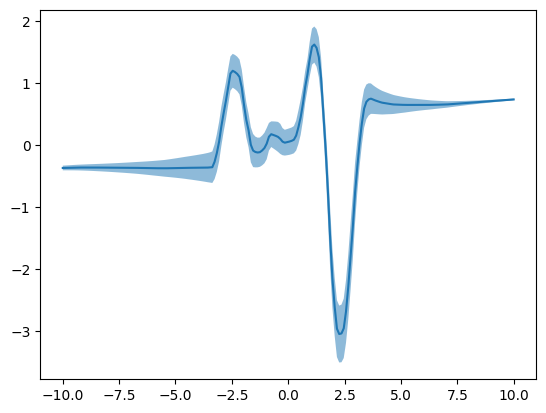

In [6]:
x_test = np.linspace(-10,10,200)
x_test = torch.from_numpy(x_test[...,None]).float()
model.eval()
with torch.no_grad():
  mu, sigma = model(x_test)
plt.plot(x_test, mu)
plt.fill_between(
    x_test.ravel(),
    mu.ravel() - 1.96 * sigma.ravel(),
    mu.ravel() + 1.96 * sigma.ravel(),
    alpha=0.5,
)
plt.show()